# 1. 必要的头文件

In [1]:
import torch
import torchvision
import time
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm.notebook import tqdm
import os
import scipy.io
from random import random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize
from matplotlib.colorbar import ColorbarBase
import matplotlib.cm as cm
import gc
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import pandas
from load_data import MyData  # self-made
from data_preprocess import generate_eegmap
from data_preprocess import generate_eegmap_chunks
from data_preprocess import generate_eegstrip
from img_show import draw_eegmap

In [2]:
root_dir = "../data/eegmap_chunks"
exper_dir = "rest"
# condition_dir: hc, mcs, uws
condi_dir = "hc"
dataset = MyData(root_dir, exper_dir, condi_dir) # eg.conditionA/hc
for person in tqdm(range(len(dataset))):  # 12种情况中的1种，其中的所有被试
    # filepath是最子文件夹中每个.mat文件的名字
    # path是包含当前情况的.mat文件的子文件夹
    filename = os.path.join(dataset.path, dataset.file_path[person])  # eg. conditionA\hc\hc1.mat
    data = torch.load(filename)
    print(data.shape)

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([48, 2400, 10, 11])


# 2. 构建脑电地形图时间序列

## 数据预览

In [2]:
root_dir = "../data/eegdata_mat"
exper_dir = "rest"
# condition_dir: hc, mcs, uws
condi_dir = "hc"
dataset = MyData(root_dir, exper_dir, condi_dir) # eg.conditionA/hc
for person in tqdm(range(len(dataset))):  # 12种情况中的1种，其中的所有被试
    # filepath是最子文件夹中每个.mat文件的名字
    # path是包含当前情况的.mat文件的子文件夹
    filename = os.path.join(dataset.path, dataset.file_path[person])  # eg. conditionA\hc\hc1.mat
    data = scipy.io.loadmat(filename)  # 读取该被试的数据为字典
    data = data['datas']  # 键值对读取59*2400*[paras]的数据矩阵
    print(data.shape)

  0%|          | 0/18 [00:00<?, ?it/s]

(59, 2400, 48)
(59, 2400, 63)
(59, 2400, 40)
(59, 2400, 45)
(59, 2400, 40)
(59, 2400, 36)
(59, 2400, 49)
(59, 2400, 46)
(59, 2400, 50)
(59, 2400, 46)
(59, 2400, 49)
(59, 2400, 48)
(59, 2400, 48)
(59, 2400, 49)
(59, 2400, 47)
(59, 2400, 47)
(59, 2400, 52)
(59, 2400, 49)


## 2.1.1  每个被试的[59×2400×段数]->[10×11×2400×分组数]

In [3]:
my_index = np.arange(59)
print(my_index)
my_index = torch.tensor(my_index)
print(my_index)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58]
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58], dtype=torch.int32)


## 查看数据

In [3]:
# origin eeg data # 原始eeg数据
root_dir = "../data/eegmap_chunks"
exper_list = ['rest']
condi_list = ['hc','mcs','uws']
for exper_dir in exper_list:
    for condi_dir in condi_list:
        dataset = MyData(root_dir, exper_dir, condi_dir) # eg.conditionA\hc
        for person in tqdm(range(len(dataset))):  # 12种情况中的1种，其中的所有被试
            filename = os.path.join(dataset.path, dataset.file_path[person])  # eg. conditionA\hc\hc1.set.mat
            ext = os.path.splitext(filename)[1].lower()
            if ext == '.mat':
                data = scipy.io.loadmat(filename)
            elif ext == '.csv':
                data = pd.read_csv(filename).values
            elif ext == '.txt':
                data = np.loadtxt(filename)
            elif ext == '.pt':
                data = torch.load(filename)
#             data = data['datas']
#             print(np.array(data).shape)
            print(data.shape)

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([48, 2400, 10, 11])


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1051, 2400, 10, 11])


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([872, 2400, 10, 11])


# 创建EEGmap

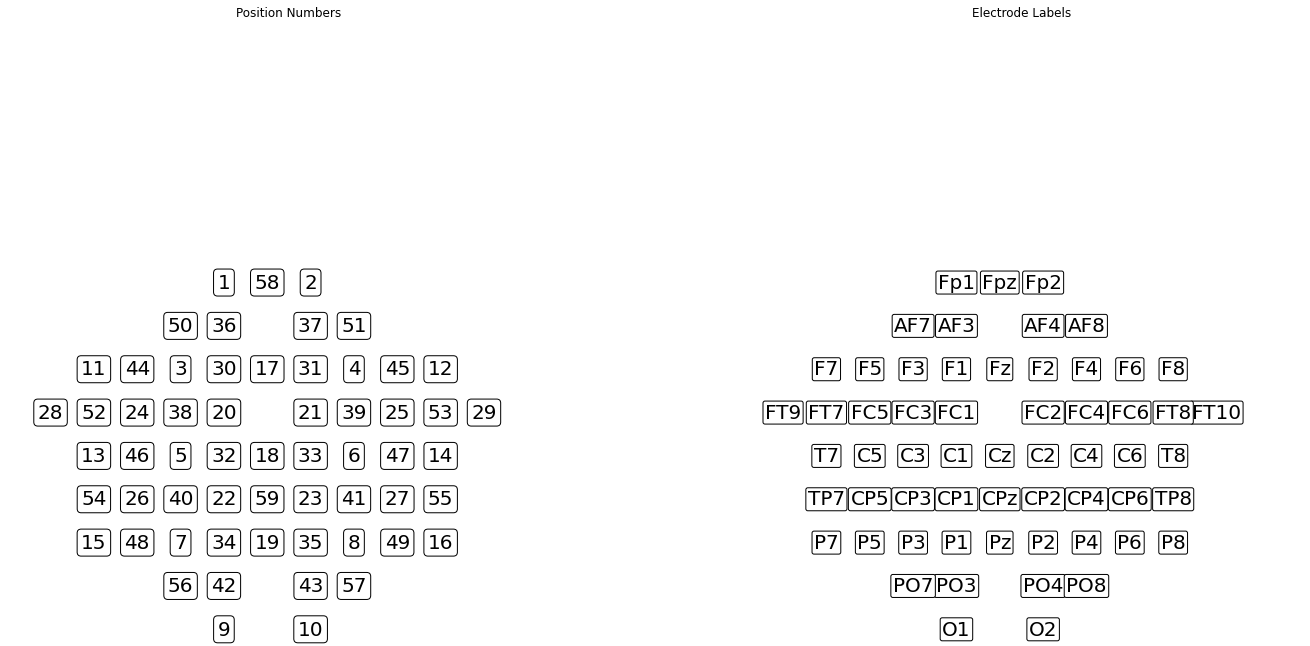

  0%|          | 0/18 [00:00<?, ?it/s]

----现在处理：hc1.mat，共48段----


  0%|          | 0/48 [00:00<?, ?it/s]

----现在处理：hc10.mat，共63段----


  0%|          | 0/63 [00:00<?, ?it/s]

----现在处理：hc11.mat，共40段----


  0%|          | 0/40 [00:00<?, ?it/s]

----现在处理：hc12.mat，共45段----


  0%|          | 0/45 [00:00<?, ?it/s]

----现在处理：hc13.mat，共40段----


  0%|          | 0/40 [00:00<?, ?it/s]

----现在处理：hc14.mat，共36段----


  0%|          | 0/36 [00:00<?, ?it/s]

----现在处理：hc15.mat，共49段----


  0%|          | 0/49 [00:00<?, ?it/s]

----现在处理：hc16.mat，共46段----


  0%|          | 0/46 [00:00<?, ?it/s]

----现在处理：hc17.mat，共50段----


  0%|          | 0/50 [00:00<?, ?it/s]

----现在处理：hc18.mat，共46段----


  0%|          | 0/46 [00:00<?, ?it/s]

----现在处理：hc21.mat，共49段----


  0%|          | 0/49 [00:00<?, ?it/s]

----现在处理：hc22.mat，共48段----


  0%|          | 0/48 [00:00<?, ?it/s]

----现在处理：hc3.mat，共48段----


  0%|          | 0/48 [00:00<?, ?it/s]

----现在处理：hc5.mat，共49段----


  0%|          | 0/49 [00:00<?, ?it/s]

----现在处理：hc6.mat，共47段----


  0%|          | 0/47 [00:00<?, ?it/s]

----现在处理：hc7.mat，共47段----


  0%|          | 0/47 [00:00<?, ?it/s]

----现在处理：hc8.mat，共52段----


  0%|          | 0/52 [00:00<?, ?it/s]

----现在处理：hc9.mat，共49段----


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

----现在处理：mcs10.mat，共41段----


  0%|          | 0/41 [00:00<?, ?it/s]

----现在处理：mcs11.mat，共52段----


  0%|          | 0/52 [00:00<?, ?it/s]

----现在处理：mcs13.mat，共48段----


  0%|          | 0/48 [00:00<?, ?it/s]

----现在处理：mcs14.mat，共49段----


  0%|          | 0/49 [00:00<?, ?it/s]

----现在处理：mcs15.mat，共51段----


  0%|          | 0/51 [00:00<?, ?it/s]

----现在处理：mcs16.mat，共50段----


  0%|          | 0/50 [00:00<?, ?it/s]

----现在处理：mcs17.mat，共50段----


  0%|          | 0/50 [00:00<?, ?it/s]

----现在处理：mcs18.mat，共48段----


  0%|          | 0/48 [00:00<?, ?it/s]

----现在处理：mcs19.mat，共44段----


  0%|          | 0/44 [00:00<?, ?it/s]

----现在处理：mcs2.mat，共45段----


  0%|          | 0/45 [00:00<?, ?it/s]

----现在处理：mcs20.mat，共47段----


  0%|          | 0/47 [00:00<?, ?it/s]

----现在处理：mcs21.mat，共40段----


  0%|          | 0/40 [00:00<?, ?it/s]

----现在处理：mcs22.mat，共42段----


  0%|          | 0/42 [00:00<?, ?it/s]

----现在处理：mcs23.mat，共52段----


  0%|          | 0/52 [00:00<?, ?it/s]

----现在处理：mcs24.mat，共51段----


  0%|          | 0/51 [00:00<?, ?it/s]

----现在处理：mcs3.mat，共39段----


  0%|          | 0/39 [00:00<?, ?it/s]

----现在处理：mcs4.mat，共61段----


  0%|          | 0/61 [00:00<?, ?it/s]

----现在处理：mcs5.mat，共50段----


  0%|          | 0/50 [00:00<?, ?it/s]

----现在处理：mcs6.mat，共37段----


  0%|          | 0/37 [00:00<?, ?it/s]

----现在处理：mcs7.mat，共59段----


  0%|          | 0/59 [00:00<?, ?it/s]

----现在处理：mcs8.mat，共47段----


  0%|          | 0/47 [00:00<?, ?it/s]

----现在处理：mcs9.mat，共48段----


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

----现在处理：uws1.mat，共51段----


  0%|          | 0/51 [00:00<?, ?it/s]

----现在处理：uws10.mat，共64段----


  0%|          | 0/64 [00:00<?, ?it/s]

----现在处理：uws11.mat，共49段----


  0%|          | 0/49 [00:00<?, ?it/s]

----现在处理：uws13.mat，共45段----


  0%|          | 0/45 [00:00<?, ?it/s]

----现在处理：uws16.mat，共32段----


  0%|          | 0/32 [00:00<?, ?it/s]

----现在处理：uws17.mat，共48段----


  0%|          | 0/48 [00:00<?, ?it/s]

----现在处理：uws2.mat，共48段----


  0%|          | 0/48 [00:00<?, ?it/s]

----现在处理：uws21.mat，共36段----


  0%|          | 0/36 [00:00<?, ?it/s]

----现在处理：uws22.mat，共46段----


  0%|          | 0/46 [00:00<?, ?it/s]

----现在处理：uws23.mat，共30段----


  0%|          | 0/30 [00:00<?, ?it/s]

----现在处理：uws24.mat，共60段----


  0%|          | 0/60 [00:00<?, ?it/s]

----现在处理：uws3.mat，共52段----


  0%|          | 0/52 [00:00<?, ?it/s]

----现在处理：uws4.mat，共65段----


  0%|          | 0/65 [00:00<?, ?it/s]

----现在处理：uws5.mat，共52段----


  0%|          | 0/52 [00:00<?, ?it/s]

----现在处理：uws6.mat，共48段----


  0%|          | 0/48 [00:00<?, ?it/s]

----现在处理：uws7.mat，共49段----


  0%|          | 0/49 [00:00<?, ?it/s]

----现在处理：uws8.mat，共49段----


  0%|          | 0/49 [00:00<?, ?it/s]

----现在处理：uws9.mat，共48段----


  0%|          | 0/48 [00:00<?, ?it/s]

../data/eegmap_direct\rest\hc\hc1.mat.pt
torch.Size([48, 2400, 9, 11])


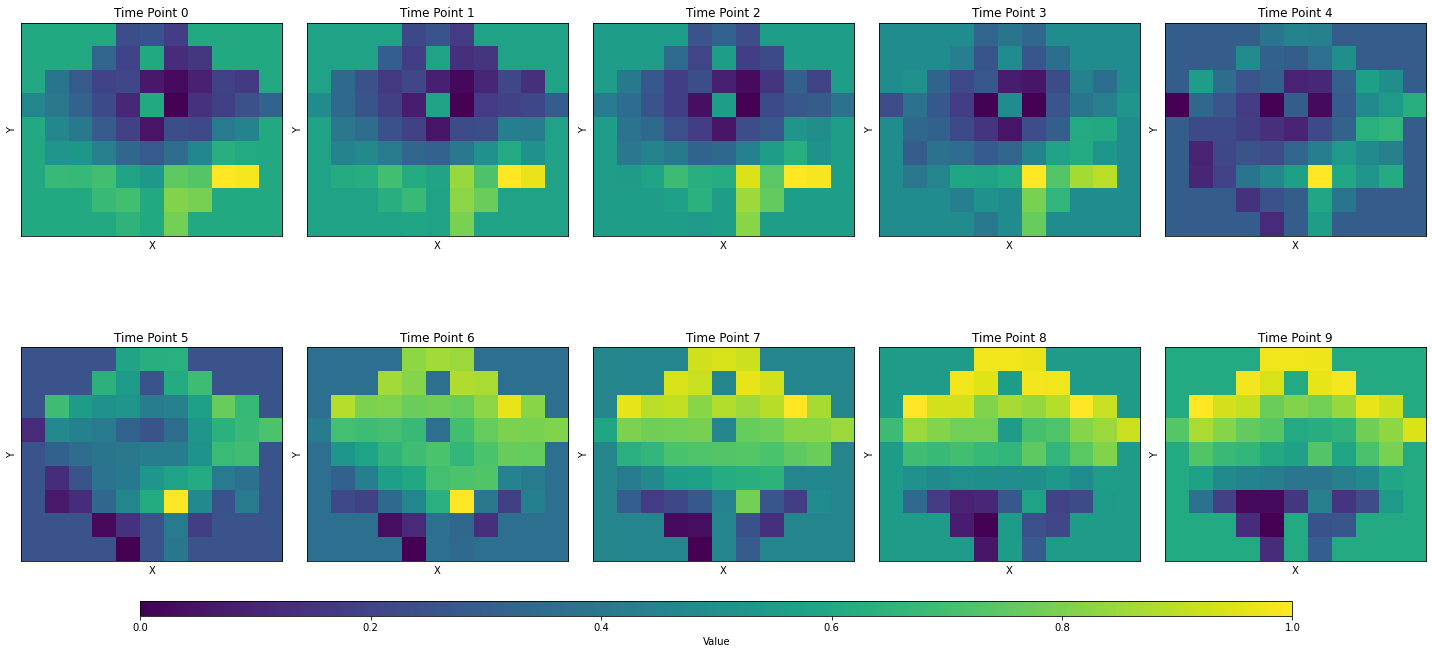

In [3]:
# origin eeg data # 原始eeg数据
root_dir = "../data/eegdata_mat"
# ====distribution index matrix # 电极分布矩阵
electric_nodes = [
    'Fp1','Fp2','F3','F4','C3','C4','P3','P4','O1','O2','F7','F8','T7','T8','P7','P8','Fz','Cz','Pz','FC1','FC2',
    'CP1','CP2','FC5','FC6','CP5','CP6','FT9','FT10','F1','F2','C1','C2','P1','P2','AF3','AF4','FC3','FC4','CP3',
    'CP4','PO3','PO4','F5','F6','C5','C6','P5','P6','AF7','AF8','FT7','FT8','TP7','TP8','PO7','PO8','Fpz','CPz'
]
matrix_index = np.array([
    [0,0,2,2,4,4,6,6,8,8,2,2,4,4,6,6,2,4,6,3,3,5,5,3,3,5,5,3,3,2,2,4,4,6,6,1,1,3,3,5,5,7,7,2,2,4,4,6,6,1,1,3,3,5,5,7,7,0,5],#  x坐标
    [4,6,3,7,3,7,3,7,4,6,1,9,1,9,1,9,5,5,5,4,6,4,6,2,8,2,8,0,10,4,6,4,6,4,6,4,6,3,7,3,7,4,6,2,8,2,8,2,8,3,7,1,9,1,9,3,7,5,5]#  y坐标
])
# ====脑电地形图可视化
draw_eegmap(electric_nodes, matrix_index)
# import sys
# sys.exit()
# ====构建脑电地形图时间序列
# set GPU usage # 使用GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# exper_list = ['conditionA','conditionB','conditionC']
exper_list = ['rest']
condi_list = ['hc','mcs','uws']
# -----------------generate single dir----------------------------
# # experimental dir: rest, conditionA, conditionB, conditionC
# exper_dir = "rest_groups"
# # condition_dir: hc, mcs, uws
# condi_dir = "hc"
# dataset = MyData(root_dir, exper_dir, condi_dir) # eg.conditionA/hc
# generate_eegmap(dataset, matrix_index, exper_dir, condi_dir, device)

# # --------------------generate all dirs------------------------------
for exper_dir in exper_list:
    for condi_dir in condi_list:
        dataset = MyData(root_dir, exper_dir, condi_dir) # eg.conditionA\hc
        generate_eegmap(dataset, matrix_index, exper_dir, condi_dir, device)

# -----------------generate all 59×1 dirs-----------------------------
# for exper_dir in exper_list:
#     for condi_dir in condi_list:
#         dataset = MyData(root_dir, exper_dir, condi_dir) # eg.conditionA\hc
#         generate_eegstrip(dataset, matrix_index, exper_dir, condi_dir, device)
        
# ====查看脑电地形图时间序列
root_dir = "../data/eegmap_direct"
exper_dir = "rest"
condi_dir = "hc"
dataset = MyData(root_dir, exper_dir, condi_dir)
person = 0
filename = os.path.join(dataset.path, dataset.file_path[person])
data_map = torch.load(filename).cpu()
print(filename)
print(data_map.size())

# 选择前十个时间点
begin = 100
end = begin+10
# 从 data_map 中提取数据
data_slice = data_map[0, begin:end, :, :]

# 创建子图
fig, axes = plt.subplots(2, 5, figsize=(20, 10))

# 循环绘制二维图
for i in range(end-begin):
    ax = axes[i // 5, i % 5]
    im = ax.imshow(data_slice[i], cmap='viridis', interpolation='nearest')
    ax.set_title('Time Point {}'.format(i))
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)

# 调整子图布局
plt.tight_layout()

# 添加统一的颜色条
cmap = cm.viridis
cbar_ax = fig.add_axes([0.1, 0.05, 0.8, 0.02])  # 调整颜色条位置
norm = Normalize(vmin=np.nanmin(data_slice), vmax=np.nanmax(data_slice))
cbar = ColorbarBase(cbar_ax, cmap=cmap, orientation='horizontal')
cbar.set_label('Value')

plt.show()
# for person in tqdm(range(len(dataset))):
#     filename = os.path.join(dataset.path, dataset.file_path[person])
#     data_map = torch.load(filename)
#     print(filename)
#     print(data_map.size())

## 2.1.2 每类所有被试的[分段数×2400×9×11]->[该类被试总分段数×2400×9×11]

In [2]:
# ====查看脑电地形图时间序列
root_dir = "../data/eegmap_direct"
exper_dir = "rest59"
condi_dir = "hc"
dataset = MyData(root_dir, exper_dir, condi_dir)
person = 0
filename = os.path.join(dataset.path, dataset.file_path[person])
data_map = torch.load(filename).cpu()
print(filename)
print(data_map.size())

# 选择前十个时间点
begin = 100
end = begin+10
# 从 data_map 中提取数据
data_slice = data_map[0, 109, :, :]
print(data_slice)

../data/eegmap_direct\rest59\hc\hc1.mat.pt
torch.Size([48, 2400, 59, 1])
tensor([[ 14.0871],
        [ 13.8901],
        [ 11.4281],
        [  8.8792],
        [  1.9434],
        [ -0.9906],
        [-22.5272],
        [-17.6982],
        [-18.6872],
        [-12.0070],
        [ 14.8673],
        [ 11.8794],
        [  4.4899],
        [  7.1707],
        [ -9.0969],
        [ -2.6523],
        [  7.5805],
        [ -1.5443],
        [-17.2902],
        [  4.7990],
        [  0.4329],
        [ -6.9784],
        [ -8.5096],
        [  7.8609],
        [  6.5713],
        [ -5.1416],
        [ -5.3652],
        [  4.8031],
        [ 12.7885],
        [  6.1815],
        [  6.7528],
        [ -0.3309],
        [  4.6091],
        [-22.5595],
        [ -6.7737],
        [ 12.5995],
        [ 13.3827],
        [  5.6269],
        [  1.4783],
        [ -6.1357],
        [ -6.8827],
        [-23.5342],
        [-13.7872],
        [ 12.2143],
        [ 13.6159],
        [  2.4798],
       

In [3]:
root_dir = "../data/eegmap_direct_new"
# single process
# exper_dir = "conditionB"
# condi_dir = "hc"
# group process
# exper_list = ['conditionA','conditionB','conditionC']
exper_list = ['rest']
condi_list = ['hc','mcs','uws']
for exper_dir in exper_list:
    for condi_dir in condi_list:
        generate_eegmap_chunks(root_dir, exper_dir, condi_dir)

  0%|          | 0/18 [00:00<?, ?it/s]

../data/eegmap_direct_new\rest\hc\hc1.mat.pt
torch.Size([48, 2400, 9, 11])
../data/eegmap_direct_new\rest\hc\hc10.mat.pt
torch.Size([63, 2400, 9, 11])
../data/eegmap_direct_new\rest\hc\hc11.mat.pt
torch.Size([40, 2400, 9, 11])
../data/eegmap_direct_new\rest\hc\hc12.mat.pt
torch.Size([45, 2400, 9, 11])
../data/eegmap_direct_new\rest\hc\hc13.mat.pt
torch.Size([40, 2400, 9, 11])
../data/eegmap_direct_new\rest\hc\hc14.mat.pt
torch.Size([36, 2400, 9, 11])
../data/eegmap_direct_new\rest\hc\hc15.mat.pt
torch.Size([49, 2400, 9, 11])
../data/eegmap_direct_new\rest\hc\hc16.mat.pt
torch.Size([46, 2400, 9, 11])
../data/eegmap_direct_new\rest\hc\hc17.mat.pt
torch.Size([50, 2400, 9, 11])
../data/eegmap_direct_new\rest\hc\hc18.mat.pt
torch.Size([46, 2400, 9, 11])
../data/eegmap_direct_new\rest\hc\hc21.mat.pt
torch.Size([49, 2400, 9, 11])
../data/eegmap_direct_new\rest\hc\hc22.mat.pt
torch.Size([48, 2400, 9, 11])
../data/eegmap_direct_new\rest\hc\hc3.mat.pt
torch.Size([48, 2400, 9, 11])
../data/eegmap

  0%|          | 0/22 [00:00<?, ?it/s]

../data/eegmap_direct_new\rest\mcs\mcs10.mat.pt
torch.Size([41, 2400, 9, 11])
../data/eegmap_direct_new\rest\mcs\mcs11.mat.pt
torch.Size([52, 2400, 9, 11])
../data/eegmap_direct_new\rest\mcs\mcs13.mat.pt
torch.Size([48, 2400, 9, 11])
../data/eegmap_direct_new\rest\mcs\mcs14.mat.pt
torch.Size([49, 2400, 9, 11])
../data/eegmap_direct_new\rest\mcs\mcs15.mat.pt
torch.Size([51, 2400, 9, 11])
../data/eegmap_direct_new\rest\mcs\mcs16.mat.pt
torch.Size([50, 2400, 9, 11])
../data/eegmap_direct_new\rest\mcs\mcs17.mat.pt
torch.Size([50, 2400, 9, 11])
../data/eegmap_direct_new\rest\mcs\mcs18.mat.pt
torch.Size([48, 2400, 9, 11])
../data/eegmap_direct_new\rest\mcs\mcs19.mat.pt
torch.Size([44, 2400, 9, 11])
../data/eegmap_direct_new\rest\mcs\mcs2.mat.pt
torch.Size([45, 2400, 9, 11])
../data/eegmap_direct_new\rest\mcs\mcs20.mat.pt
torch.Size([47, 2400, 9, 11])
../data/eegmap_direct_new\rest\mcs\mcs21.mat.pt
torch.Size([40, 2400, 9, 11])
../data/eegmap_direct_new\rest\mcs\mcs22.mat.pt
torch.Size([42, 2

  0%|          | 0/18 [00:00<?, ?it/s]

../data/eegmap_direct_new\rest\uws\uws1.mat.pt
torch.Size([51, 2400, 9, 11])
../data/eegmap_direct_new\rest\uws\uws10.mat.pt
torch.Size([64, 2400, 9, 11])
../data/eegmap_direct_new\rest\uws\uws11.mat.pt
torch.Size([49, 2400, 9, 11])
../data/eegmap_direct_new\rest\uws\uws13.mat.pt
torch.Size([45, 2400, 9, 11])
../data/eegmap_direct_new\rest\uws\uws16.mat.pt
torch.Size([32, 2400, 9, 11])
../data/eegmap_direct_new\rest\uws\uws17.mat.pt
torch.Size([48, 2400, 9, 11])
../data/eegmap_direct_new\rest\uws\uws2.mat.pt
torch.Size([48, 2400, 9, 11])
../data/eegmap_direct_new\rest\uws\uws21.mat.pt
torch.Size([36, 2400, 9, 11])
../data/eegmap_direct_new\rest\uws\uws22.mat.pt
torch.Size([46, 2400, 9, 11])
../data/eegmap_direct_new\rest\uws\uws23.mat.pt
torch.Size([30, 2400, 9, 11])
../data/eegmap_direct_new\rest\uws\uws24.mat.pt
torch.Size([60, 2400, 9, 11])
../data/eegmap_direct_new\rest\uws\uws3.mat.pt
torch.Size([52, 2400, 9, 11])
../data/eegmap_direct_new\rest\uws\uws4.mat.pt
torch.Size([65, 2400

# 3. 准备数据集

## 3.1 划分数据集-交叉验证

In [4]:
# 定义函数用于保存数据集
def save_dataset(data, exper_dir, subset, mode, fold):
    torch.save(data, f"../data/eegmap_split_new/{exper_dir}/{mode}/{subset}/{exper_dir}_{subset}_{mode}_{fold}.pt")

# test_percentage = 0 # 设置测试集比例
fold_num = 5 # 设置交叉验证折数
# 选择被试种类
for exper_dir in exper_list:
    print(f"========正在划分{exper_dir}========")
    hc_path = f"../data/eegmap_chunks_new/{exper_dir}/hc/{exper_dir}_hc.pt"
    mcs_path = f"../data/eegmap_chunks_new/{exper_dir}/mcs/{exper_dir}_mcs.pt"
    uws_path = f"../data/eegmap_chunks_new/{exper_dir}/uws/{exper_dir}_uws.pt"
    hc = torch.load(hc_path)
    mcs = torch.load(mcs_path)
    uws = torch.load(uws_path)
    print(f"{exper_dir}实验下共有EEG数据段：")
    print(f"HC: {hc.size(0)}，MCS: {mcs.size(0)}，UWS: {uws.size(0)}")
    hc_all = hc.size(0)
    mcs_all = mcs.size(0)
    uws_all = uws.size(0)
    # 生成随机种子
    torch.manual_seed(32)
#     # ====1. test dataset，划分测试集
#     # 生成随机种子
#     torch.manual_seed(32)
#     # 生成随机索引
#     hc_indices = torch.randperm(len(hc))
#     mcs_indices = torch.randperm(len(mcs))
#     uws_indices = torch.randperm(len(uws))
#     # hc
#     test_end = int(test_percentage * len(hc))
#     test_hc_indices = hc_indices[:test_end]
#     test_hc = hc[test_hc_indices]
#     torch.save(test_hc, f"../data/eegmap_split/{exper_dir}/test/hc/{exper_dir}_hc_test.pt")
#     hc = hc[hc_indices[test_end:]]
#     # mcs
#     test_end = int(test_percentage * len(mcs))
#     test_mcs_indices = mcs_indices[:test_end]
#     test_mcs = mcs[test_mcs_indices]
#     torch.save(test_mcs, f"../data/eegmap_split/{exper_dir}/test/mcs/{exper_dir}_mcs_test.pt")
#     mcs = mcs[mcs_indices[test_end:]]
#     #uws
#     test_end = int(test_percentage * len(uws))
#     test_uws_indices = uws_indices[:test_end]
#     test_uws = uws[test_uws_indices]
#     torch.save(test_uws, f"../data/eegmap_split/{exper_dir}/test/uws/{exper_dir}_uws_test.pt")
#     uws = uws[uws_indices[test_end:]]
#     print(f"测试集中有EEG数据段：")
#     print(f"HC: {hc_all - hc.size(0)}，MCS: {mcs_all - mcs.size(0)}，UWS: {uws_all - uws.size(0)}")
#     # 清理内存
#     del hc_indices, mcs_indices, uws_indices, test_hc_indices, test_mcs_indices, test_uws_indices
#     del test_hc, test_mcs, test_uws
#     gc.collect()
#     torch.cuda.empty_cache()

    # ====2. train dataset，划分训练集和验证集
    # 生成随机索引
    hc_indices = torch.randperm(len(hc))
    mcs_indices = torch.randperm(len(mcs))
    uws_indices = torch.randperm(len(uws))
    # 划分数据集并保存
    for fold in tqdm(range(fold_num)):
        # 划分 hc 数据集
        len_hc = len(hc)
        val_size = len_hc // fold_num  # 每一折的验证集大小
        val_start = fold * val_size  # 验证集起始索引
        val_end = min((fold + 1) * val_size, len_hc)  # 验证集结束索引
        train_hc_indices = torch.cat([hc_indices[:val_start], hc_indices[val_end:]])
        val_hc_indices = hc_indices[val_start:val_end]
        train_hc = hc[train_hc_indices]
        val_hc = hc[val_hc_indices]
        save_dataset(train_hc, exper_dir, 'hc', 'train', fold)
        save_dataset(val_hc, exper_dir, 'hc', 'test', fold)
        hc_val = val_size
        hc_train = len_hc - val_size
        # 划分 mcs 数据集
        len_mcs = len(mcs)
        val_size = len_mcs // fold_num
        val_start = fold * val_size
        val_end = min((fold + 1) * val_size, len_mcs)
        train_mcs_indices = torch.cat([mcs_indices[:val_start], mcs_indices[val_end:]])
        val_mcs_indices = mcs_indices[val_start:val_end]
        train_mcs = mcs[train_mcs_indices]
        val_mcs = mcs[val_mcs_indices]
        save_dataset(train_mcs, exper_dir, 'mcs', 'train', fold)
        save_dataset(val_mcs, exper_dir, 'mcs', 'test', fold)
        mcs_val = val_size
        mcs_train = len_mcs - val_size
        # 划分 uws 数据集
        len_uws = len(uws)
        val_size = len_uws // fold_num
        val_start = fold * val_size
        val_end = min((fold + 1) * val_size, len_uws)
        train_uws_indices = torch.cat([uws_indices[:val_start], uws_indices[val_end:]])
        val_uws_indices = uws_indices[val_start:val_end]
        train_uws = uws[train_uws_indices]
        val_uws = uws[val_uws_indices]
        save_dataset(train_uws, exper_dir, 'uws', 'train', fold)
        save_dataset(val_uws, exper_dir, 'uws', 'test', fold)
        uws_val = val_size
        uws_train = len_uws - val_size
        if fold == 0:
            print(f"训练集中每折有EEG数据段：")
            print(f"HC: {hc_train}，MCS: {mcs_train}，UWS: {uws_train}")
            print(f"验证集中每折有EEG数据段：")
            print(f"HC: {hc_val}，MCS: {mcs_val}，UWS: {uws_val}")
        # 清理内存
        del train_hc_indices, train_mcs_indices, train_uws_indices,
        del val_hc_indices, val_mcs_indices, val_uws_indices
        del train_hc, train_mcs, train_uws, val_hc, val_mcs, val_uws
        gc.collect()
        torch.cuda.empty_cache()
    
    # 清理内存
    del hc_indices, mcs_indices, uws_indices
    del hc, mcs, uws
    gc.collect()
    torch.cuda.empty_cache()

========正在划分rest========
rest实验下共有EEG数据段：
HC: 852，MCS: 1051，UWS: 872


  0%|          | 0/5 [00:00<?, ?it/s]

训练集中每折有EEG数据段：
HC: 682，MCS: 841，UWS: 698
验证集中每折有EEG数据段：
HC: 170，MCS: 210，UWS: 174


## 3.2 为数据集打标签

In [26]:
a = "1"
print(str.isdigit(a))

True


In [ ]:
classification_list = ['HC/DOC', 'MCS/UWS']
# classify = classification_list[0]
mode_list = ['train', 'test']
exper_list = ['rest']
condi_list = ['hc','mcs','uws']
# 生成随机种子
torch.manual_seed(32)
for classify in classification_list:
    hc_flag = 0
    mcs_flag = 0
    uws_flag = 0
    for exper_dir in exper_list:
        root_dir = f"../data/eegmap_split_new/{exper_dir}"
        for mode in mode_list:
            condi_dir = "hc"
            dataset = MyData(root_dir, mode, condi_dir) # eg.conditionA/hc
            for person in tqdm(range(len(dataset))):
                # load filename
                filename = os.path.join(dataset.path, dataset.file_path[person])
                data_map = torch.load(filename)
                name_without_extension = os.path.splitext(os.path.basename(filename))[0]
                last_part = name_without_extension.split('_')[-1]
                if str.isdigit(last_part):
                    # set label
                    label = torch.zeros(data_map.size(0)) # label = 0
                    if classify == 'HC/DOC':
                        save_path = f"../data/eegmap_split_new/{exper_dir}/{mode}/{condi_dir}/{name_without_extension}_hc_doc_label.pt"
                    elif classify == 'MCS/UWS':
                        save_path = f"../data/eegmap_split_new/{exper_dir}/{mode}/{condi_dir}/{name_without_extension}_mcs_uws_label.pt"
                    torch.save(label, save_path)
                    # print label
                    if hc_flag == 0:
                        print(f"被试类别：{condi_dir}, 标签：{label[0]}")
                        hc_flag = hc_flag + 1
                    del label,data_map,filename
                    gc.collect()
                    torch.cuda.empty_cache()
            condi_dir = "mcs"
            dataset = MyData(root_dir, mode, condi_dir) # eg.conditionA/hc
            for person in tqdm(range(len(dataset))):
                filename = os.path.join(dataset.path, dataset.file_path[person])
                data_map = torch.load(filename)
                name_without_extension = os.path.splitext(os.path.basename(filename))[0]
                last_part = name_without_extension.split('_')[-1]
                if str.isdigit(last_part):
                    if classify == 'HC/DOC':
                        label = torch.ones(data_map.size(0)) # label = 1, for HC/DOC
                        save_path = f"../data/eegmap_split_new/{exper_dir}/{mode}/{condi_dir}/{name_without_extension}_hc_doc_label.pt"
                    elif classify == 'MCS/UWS':
                        label = torch.zeros(data_map.size(0)) # label = 0, for MCS/UWS
                        save_path = f"../data/eegmap_split_new/{exper_dir}/{mode}/{condi_dir}/{name_without_extension}_mcs_uws_label.pt"
                    torch.save(label, save_path)
                    if mcs_flag == 0:
                        print(f"被试类别：{condi_dir}, 标签：{label[0]}")
                        mcs_flag = mcs_flag + 1
                    del label,data_map,filename
                    gc.collect()
                    torch.cuda.empty_cache()
            condi_dir = "uws"
            dataset = MyData(root_dir, mode, condi_dir) # eg.conditionA/hc
            for person in tqdm(range(len(dataset))):
                filename = os.path.join(dataset.path, dataset.file_path[person])
                data_map = torch.load(filename)
                name_without_extension = os.path.splitext(os.path.basename(filename))[0]
                last_part = name_without_extension.split('_')[-1]
                if str.isdigit(last_part):
                    label = torch.ones(data_map.size(0)) # label = 1
                    if classify == 'HC/DOC':
                        save_path = f"../data/eegmap_split_new/{exper_dir}/{mode}/{condi_dir}/{name_without_extension}_hc_doc_label.pt"
                    elif classify == 'MCS/UWS':
                        save_path = f"../data/eegmap_split_new/{exper_dir}/{mode}/{condi_dir}/{name_without_extension}_mcs_uws_label.pt"
                    torch.save(label, save_path)
                    if uws_flag == 0:
                        print(f"被试类别：{condi_dir}, 标签：{label[0]}")
                        uws_flag = uws_flag + 1
                    del label,data_map,filename
                    gc.collect()
                    torch.cuda.empty_cache()

  0%|          | 0/5 [00:00<?, ?it/s]

被试类别：hc, 标签：0.0


  0%|          | 0/5 [00:00<?, ?it/s]

被试类别：mcs, 标签：1.0


  0%|          | 0/5 [00:00<?, ?it/s]

被试类别：uws, 标签：1.0


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

被试类别：hc, 标签：0.0


  0%|          | 0/10 [00:00<?, ?it/s]

被试类别：mcs, 标签：0.0


# View Models

In [ ]:
import torch
from torchviz import make_dot
import hiddenlayer as hl
from network_cnn_lstm_2 import MyNetwork

# 创建一个模型实例
model = MyNetwork()

# 使用 hiddenlayer 可视化模型结构
transforms = [hl.transforms.Prune('Constant'), hl.transforms.Prune('Identity')]
# 仅传递模型大层的 forward 函数
graph = hl.build_graph(model, torch.zeros([110, 1, 1, 2400]), transforms=transforms)
graph.theme = hl.graph.THEMES['blue'].copy()  # 选择一个主题
graph.save("network_structure.png", format="png")

# 显示图片
from IPython.display import Image
Image("network_structure.png")

# from network_cnn_lstm_4 import MyNetwork
# from network_cnn_lstm import MyNetwork